<a href="https://colab.research.google.com/github/AlexanderBelfort/MDPRKT/blob/main/SVMNB_New_Model_Report_150221.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import pickle

# Set Random seed
np.random.seed(500)

# Add the Data using pandas

Corpus = pd.read_csv(r"SVM_vs_NB.csv", encoding='latin-1')
#header=None, error_bad_lines=False)
'''col_name = Corpus.columns[0]
Corpus=Corpus.rename(columns = {col_name:'text'})

col_name2 = Corpus.columns[1]
Corpus=Corpus.rename(columns = {col_name2:'label'})
'''
Corpus.head()

,text,label
0,Cholesterol gallstones result from oversaturat...,__GALLSTONES__
1,Gallstones are highly prevalent in most develo...,__GALLSTONES__
2,Lung cancer does not usually cause noticeable ...,__OTHER_DISEASES__
3,Multiple studies on the subjet of gallstones h...,__GALLSTONES__
4,Research indicates that gallstones have been h...,__GALLSTONES__


In [81]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Step - 1: Data Pre-processing - This will help in getting better results through the classification algorithms

# Step - 1a : Remove blank rows if any.
Corpus['text'].dropna(inplace=True)

# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV


def text_preprocessing(text):
    # Step - 1b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
    text = text.lower()

    # Step - 1c : Tokenization : In this each entry in the corpus will be broken into set of words
    text_words_list = word_tokenize(text)

    # Step - 1d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(text_words_list):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
        # The final processed set of words for each iteration will be stored in 'text_final'
    return str(Final_words)


Corpus['text_final'] = Corpus['text'].map(text_preprocessing)

# Step - 2: Split the model into Train and Test Data set
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'], Corpus['label'],
                                                                    test_size=0.3)

# Step - 3: Label encode the target variable  - This is done to transform Categorical data of string type in the data set into numerical values
Encoder = LabelEncoder()
Encoder.fit(Train_Y)
Train_Y = Encoder.transform(Train_Y)
Test_Y = Encoder.transform(Test_Y)

# Step - 4: Vectorize the words by using TF-IDF Vectorizer - This is done to find how important a word in document is in comaprison to the corpus
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus['text_final'])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

# Step - 5: Now we can run different algorithms to classify out data check for accuracy

# Classifier - Algorithm - Naive Bayes
# fit the training dataset on the classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf, Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ", accuracy_score(predictions_NB, Test_Y) * 100)

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf, Train_Y)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, Test_Y) * 100)


# Saving Encdoer, TFIDF Vectorizer and the trained model for future infrerencing/prediction

# saving encoder to disk
filename = 'labelencoder_fitted.pkl'
pickle.dump(Encoder, open(filename, 'wb'))

# saving TFIDF Vectorizer to disk
filename = 'Tfidf_vect_fitted.pkl'
pickle.dump(Tfidf_vect, open(filename, 'wb'))

# saving the both models to disk
filename = 'svm_trained_model.sav'
pickle.dump(SVM, open(filename, 'wb'))

filename = 'nb_trained_model.sav'
pickle.dump(Naive, open(filename, 'wb'))

print("Files saved to disk! Proceed to inference.py")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Naive Bayes Accuracy Score ->  88.0
SVM Accuracy Score ->  96.0
Files saved to disk! Proceed to inference.py


In [79]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
import pickle
import ast

# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV


def text_preprocessing(text):
    # Step - 1b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
    text = text.lower()

    # Step - 1c : Tokenization : In this each entry in the corpus will be broken into set of words
    text_words_list = word_tokenize(text)

    # Step - 1d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(text_words_list):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
        # The final processed set of words for each iteration will be stored in 'text_final'
    return str(Final_words)


# Loading Label encoder
labelencode = pickle.load(open('labelencoder_fitted.pkl', 'rb'))

# Loading TF-IDF Vectorizer
Tfidf_vect = pickle.load(open('Tfidf_vect_fitted.pkl', 'rb'))

# Loading models
SVM = pickle.load(open('svm_trained_model.sav', 'rb'))
Naive = pickle.load(open('nb_trained_model.sav', 'rb'))


# Inference
sample_text = "Do I need to have my gallbladder removed?"
sample_text_processed = text_preprocessing(sample_text)
sample_text_processed_vectorized = Tfidf_vect.transform([sample_text_processed])

prediction_SVM = SVM.predict(sample_text_processed_vectorized)
prediction_Naive = Naive.predict(sample_text_processed_vectorized)

print("Prediction from SVM Model:", labelencode.inverse_transform(prediction_SVM)[0])
print("Prediction from NB Model:", labelencode.inverse_transform(prediction_Naive)[0])

Prediction from SVM Model: __GALLSTONES__
Prediction from NB Model: __GALLSTONES__


In [156]:
# Inference
sample_text = "How do you treat cancer?"
sample_text_processed = text_preprocessing(sample_text)
sample_text_processed_vectorized = Tfidf_vect.transform([sample_text_processed])

prediction_SVM = SVM.predict(sample_text_processed_vectorized)
prediction_Naive = Naive.predict(sample_text_processed_vectorized)

print("Prediction from SVM Model:", labelencode.inverse_transform(prediction_SVM)[0])
print("Prediction from NB Model:", labelencode.inverse_transform(prediction_Naive)[0])

Prediction from SVM Model: __OTHER_DISEASES__
Prediction from NB Model: __GALLSTONES__


In [155]:
# Inference
sample_text = "I have bile problems."
sample_text_processed = text_preprocessing(sample_text)
sample_text_processed_vectorized = Tfidf_vect.transform([sample_text_processed])

prediction_SVM = SVM.predict(sample_text_processed_vectorized)
prediction_Naive = Naive.predict(sample_text_processed_vectorized)

print("Prediction from SVM Model:", labelencode.inverse_transform(prediction_SVM)[0])
print("Prediction from NB Model:", labelencode.inverse_transform(prediction_Naive)[0])

Prediction from SVM Model: __GALLSTONES__
Prediction from NB Model: __GALLSTONES__


In [154]:
# Inference
sample_text = "I feel like I have dementia."
sample_text_processed = text_preprocessing(sample_text)
sample_text_processed_vectorized = Tfidf_vect.transform([sample_text_processed])

prediction_SVM = SVM.predict(sample_text_processed_vectorized)
prediction_Naive = Naive.predict(sample_text_processed_vectorized)

print("Prediction from SVM Model:", labelencode.inverse_transform(prediction_SVM)[0])
print("Prediction from NB Model:", labelencode.inverse_transform(prediction_Naive)[0])

Prediction from SVM Model: __OTHER_DISEASES__
Prediction from NB Model: __OTHER_DISEASES__


In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
acc_data = pd.read_csv(r"SVM_vs_NB_scores_binary.csv", encoding='latin-1')


In [124]:
acc_data

,Algorithm,Accuracy Score
0,Naive Bayes,0.88
1,Support Vector Machine,0.96


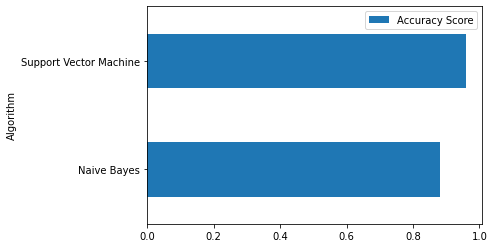

In [132]:
#### ACCURACY COMPARISON PLOT

accc = acc_data.plot.barh(x='Algorithm', y='Accuracy Score', rot=0)


In [134]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

#SVM REPORT
print(classification_report(Test_Y ,predictions_SVM))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.93      0.96        14

    accuracy                           0.96        25
   macro avg       0.96      0.96      0.96        25
weighted avg       0.96      0.96      0.96        25



In [136]:
#NB REPORT
print(classification_report(Test_Y,predictions_NB))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       1.00      0.79      0.88        14

    accuracy                           0.88        25
   macro avg       0.89      0.89      0.88        25
weighted avg       0.91      0.88      0.88        25



In [184]:
naive_bayesss = classification_report(Test_Y,predictions_NB, output_dict=True)

In [183]:
Encoder.classes_

array(['__GALLSTONES__', '__OTHER_DISEASES__'], dtype=object)

In [185]:
naive_bayesss

{'0': {'f1-score': 0.88,
  'precision': 0.7857142857142857,
  'recall': 1.0,
  'support': 11},
 '1': {'f1-score': 0.88,
  'precision': 1.0,
  'recall': 0.7857142857142857,
  'support': 14},
 'accuracy': 0.88,
 'macro avg': {'f1-score': 0.88,
  'precision': 0.8928571428571428,
  'recall': 0.8928571428571428,
  'support': 25},
 'weighted avg': {'f1-score': 0.88,
  'precision': 0.9057142857142857,
  'recall': 0.88,
  'support': 25}}

In [187]:
svmmmm = classification_report(Test_Y,predictions_SVM, output_dict=True)
svmmmm

{'0': {'f1-score': 0.9565217391304348,
  'precision': 0.9166666666666666,
  'recall': 1.0,
  'support': 11},
 '1': {'f1-score': 0.962962962962963,
  'precision': 1.0,
  'recall': 0.9285714285714286,
  'support': 14},
 'accuracy': 0.96,
 'macro avg': {'f1-score': 0.9597423510466989,
  'precision': 0.9583333333333333,
  'recall': 0.9642857142857143,
  'support': 25},
 'weighted avg': {'f1-score': 0.9601288244766506,
  'precision': 0.9633333333333333,
  'recall': 0.96,
  'support': 25}}

In [191]:
statisticss = pd.read_csv(r'svm_nb_stats_csv.csv')
statisticss

,Class,Model,Precision,Recall,F1,Support
0,Gallstones,SVM,0.92,1.00,0.96,11
1,Gallstones,NB,0.79,1.00,0.88,14
2,Other Diseases,SVM,1.00,0.93,0.96,14
3,Other Diseases,NB,1.00,0.79,0.88,14


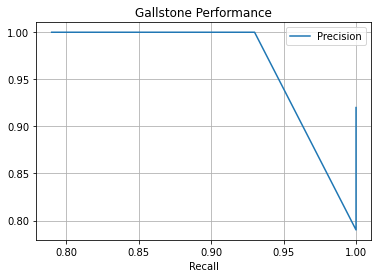

In [211]:
statisticss.plot('Recall', 'Precision')
plt.title('Gallstone Performance')
plt.grid(True)

plt.show()